# **過学習を緩和する**
過学習とはモデルが訓練データに過剰に適合してしまい，テストデータ（未経験のデータ）に対する精度が訓練データに対する精度と比較して劣ってしまう現象のことです．

過学習はネットワークのパラメタ数の多さ，訓練データの少なさ，訓練データの偏りなど様々な要因によって引き起こされ，完全になくすことはできません．
しかし学習の方法や訓練データの前処理などによって過学習を抑えることはできます．
本節では以下のような過学習を抑制するためのテクニックについて実験を行います．

* Weight decay
* Dropout
* Data augmentation

## **0 準備**
まずは実験を行うためのネットワークを準備します．
題材には以前に使用したCIFAR-10の分類ネットワークを用います．
変更点としては学習をGPU上で行うこと，ネットワーク構造が多少変化していることが挙げられます．

**この先に進む前にColaboratoryのランタイムタイプがGPUになっていることを確認して下さい．**

以下のコードを実行して"cuda:0"と表示されればOKです．
もし"cpu"と表示された場合はColaboratoryのランタイムタイプがCPUになっているため，ランタイムタイプを変更してから再度実行して下さい．

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from google.colab import drive # driveを接続
drive.mount('/content/drive')

# drive中の課題ファイルのあるディレクトリに移動
%cd /content/drive/My Drive/Colab Notebooks/先端人工知能論I/20220607/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/先端人工知能論I/20220607


以下のコードを実行すればネットワークを訓練する準備が整います．

In [4]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# random seed 設定
import random
torch.manual_seed(1111)
np.random.seed(1111)
random.seed(1111)

batch_size = 128 #一度に学習するデータ量
loss_interval = 50 #test_lossを計算する間隔

#変換器の作成
transform = transforms.Compose(
    [transforms.ToTensor(),  # torch.Tensor へ変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 正規化する
 
#訓練データのダウンロードと変換設定
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#訓練データのローダ(読み込み器)の作成
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
 
#テストデータのダウンロードと変換設定
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#テストデータのローダ(読み込み器)の作成
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

#ネットワークの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv4 = nn.Conv2d(256, 16, 3, padding = 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#ネットワークを訓練する関数
def train(net, criterion, optimizer, n_epoch = 15):
    # Batch normalization や本節で実験を行う Dropout など訓練時と推論時(評価時)に挙動が変化する処理が存在します．
    # そのため一般的には訓練前にネットワークを訓練モードに切り替える必要があります．
    net.train()  # ネットワークを訓練状態へ切り替える
    train_loss = []
    test_loss = []
    for epoch in range(n_epoch):  # 訓練データを複数回(n_epoch 周分)学習する
        for i, data in enumerate(trainloader, 0):
            # ローダからデータを読み込む; データは [inputs, labels] の形で取得される
            inputs, labels = data[0].to(device), data[1].to(device)

            # 勾配を0に初期化する(逆伝播に備える)
            optimizer.zero_grad()

            # 順伝播 + 逆伝播 + 最適化
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 統計を計算する
            if i % loss_interval == (loss_interval - 1):    # loss_interval ミニバッチ毎に計算する
                train_loss.append(loss.item())

                # テストデータに対する損失を計算する(訓練はしない)
                # net.eval()でネットワークを推論(評価)モードに変更してテストデータを扱う場合もあります．
                # ただし本節では過学習について比較を行うので，訓練とテストにおける損失の計算を平等に行うために使用しません．
                with torch.no_grad():  #勾配計算をしない宣言(逆伝播用の計算グラフを作成しないことでメモリ節約，速度向上する)
                    data = iter(testloader).next()  #  テストデータを1ミニバッチ取得する
                    inputs, labels = data[0].to(device), data[1].to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    test_loss.append(loss.item())

        print('epoch {}/{} finished'.format(epoch+1,n_epoch))
            
    print('Finished Training')
    return train_loss, test_loss

# 損失の変遷を表示する関数
def show_loss(train_loss, test_loss):
    plt.xlabel("iter")
    plt.ylabel("loss")
    x = [i*loss_interval for i in range(len(train_loss))]
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, test_loss, label='test_loss')
    plt.legend()
    plt.show()

# ネットワークの予測精度を計算する関数
def check_accuracy(net):
    # Batch normalization や本節で実験を行う Dropout など訓練時と推論時(評価時)に挙動が変化する処理が存在します．
    # そのため一般的には推論前にネットワークを推論(評価)モードに切り替える必要があります．
    net.eval()  # ネットワークを評価状態へ切り替える
    ret = []
    with torch.no_grad():  #勾配計算をしない宣言(逆伝播用の計算グラフを作成しないことでメモリ節約，速度向上する)
        for loader, name in [[trainloader, 'train'], [testloader, 'test']]:
            correct = 0
            total = 0
            for data in loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            ret.append(100 * correct / total)
            print('Accuracy of the network on the {} images: {:.2f} %'.format(name, ret[-1]))

    return ret

Files already downloaded and verified
Files already downloaded and verified


## **1 過学習の確認**
まずは何も過学習に対する対策を行わずに学習を行い，訓練データとテストデータに対する損失と精度の差を確認します．

以下のコードを実行すると学習が開始されます（数分かかります）．

epoch 1/15 finished
epoch 2/15 finished
epoch 3/15 finished
epoch 4/15 finished
epoch 5/15 finished
epoch 6/15 finished
epoch 7/15 finished
epoch 8/15 finished
epoch 9/15 finished
epoch 10/15 finished
epoch 11/15 finished
epoch 12/15 finished
epoch 13/15 finished
epoch 14/15 finished
epoch 15/15 finished
Finished Training


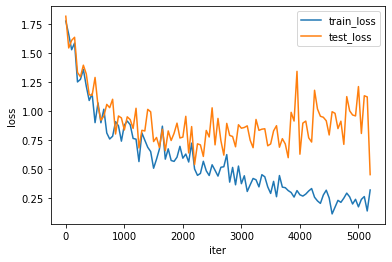

In [5]:
net = Net()  #ネットワークの生成
net.to(device)  #ネットワークをGPUへ転送

#損失関数と optimizer の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) # 訓練を促進するため適応的optimizerであるAdamを使用します．

train_loss, test_loss = train(net, criterion, optimizer)  # ネットワークを訓練する
show_loss(train_loss, test_loss) # 損失の変遷を表示する

訓練データに対する損失である"train_loss"とテストデータに対する損失である"test_loss"が，学習を進めるにつれ乖離していくことが分かります．
損失は低いほど良く予測できていることを表すため，このモデルは訓練データに対して過剰に適合している，つまり**過学習が発生**していることになります．

以下のコードを実行すると訓練データとテストデータに対する実際の予測精度が計算されます．

In [6]:
acc = check_accuracy(net) # ネットワークの予測精度を計算する

Accuracy of the network on the train images: 95.33 %
Accuracy of the network on the test images: 76.48 %


実際の予測精度からもモデルが訓練データに過剰適合していることが分かります．

## **2 Weight decay**
ここでは過学習を抑制するテクニックの一つである Weight decay の実験を行います．

Weight decay とはネットワークの各パラメタ（重み）に制限を加えて学習することで過学習を抑制するテクニックです．具体的にはパラメタ（重み）を$w$，通常の損失を$C(w)$とした場合に新たな損失$C'(w)$を

$C'(w) = C(w) + \frac{λ}{2} \|w\|^2$

と定義し，これを使用して学習を行います．
つまりネットワークの各パラメタ（重み）が大きくなり過ぎないように制限を加えることで過学習の抑制を行います．

**PyTorch では Optimizer を定義する際に使用を宣言することで容易に Weight decay を行うことができます．**

以下のコードを実行すると Weight decay を使用した学習を開始します（数分かかります）．

epoch 1/15 finished
epoch 2/15 finished
epoch 3/15 finished
epoch 4/15 finished
epoch 5/15 finished
epoch 6/15 finished
epoch 7/15 finished
epoch 8/15 finished
epoch 9/15 finished
epoch 10/15 finished
epoch 11/15 finished
epoch 12/15 finished
epoch 13/15 finished
epoch 14/15 finished
epoch 15/15 finished
Finished Training


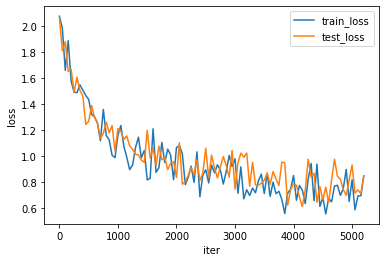

Accuracy of the network on the train images: 76.49 %
Accuracy of the network on the test images: 72.30 %


In [7]:
net = Net()  #ネットワークの生成
net.to(device)  #ネットワークをGPUへ転送

#損失関数と optimizer の定義
criterion = nn.CrossEntropyLoss()
optimizer_wd = optim.Adam(net.parameters(), lr=0.001, weight_decay=4e-3) # weight_decayを使用するoptimizer

train_loss, test_loss = train(net, criterion, optimizer_wd)  # ネットワークを訓練する
show_loss(train_loss, test_loss) # 損失の変遷を表示する
acc = check_accuracy(net) # ネットワークの予測精度を計算する関数

Weight decay を使用しない場合と比較して"train_loss"と"test_loss"の乖離が抑えられていることが分かります．

## **3 Dropout**
ここでは過学習を抑制するテクニックの一つである Dropout の実験を行います．

Dropout とは一定の割合のランダムなノードを無視して学習を行うテクニックです．下図のようにいくつかのノードを無視して学習を行います（図はDive into Deep Learningより引用）．パラメタ（重み）の更新を行うたびにどのノードを無視するかランダムに再設定します．


<img src="http://d2l.ai/_images/dropout2.svg" width=500>


これによりネットワークの自由度を小さくできるため過学習を抑えることができます．また複数ネットワークの合議によって出力を決定する"アンサンブル"と呼ばれる手法の近似であるため汎化性能が上がりやすい（過学習を抑えられる）とも言われています．

また推論時（評価時）には全てのノードを使用して計算を行います（Dropoutを無効化する）．

**PyTorch で Dropout を使用するためにはネットワークの定義時に組み込む必要があります．**
Dropout を組み込む場合は以下のようになります．

In [8]:
#Dropoutを使用するネットワークの定義
class Net_dropout(nn.Module):
    def __init__(self):
        super(Net_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv4 = nn.Conv2d(256, 16, 3, padding = 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # dropoutの定義
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.dropout2 = nn.Dropout2d(p=0.25)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout4 = nn.Dropout(p=0.35)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        x = self.fc3(x)
        return x

以下のコードを実行すると Dropout を使用した学習を開始します（数分かかります）．

epoch 1/15 finished
epoch 2/15 finished
epoch 3/15 finished
epoch 4/15 finished
epoch 5/15 finished
epoch 6/15 finished
epoch 7/15 finished
epoch 8/15 finished
epoch 9/15 finished
epoch 10/15 finished
epoch 11/15 finished
epoch 12/15 finished
epoch 13/15 finished
epoch 14/15 finished
epoch 15/15 finished
Finished Training


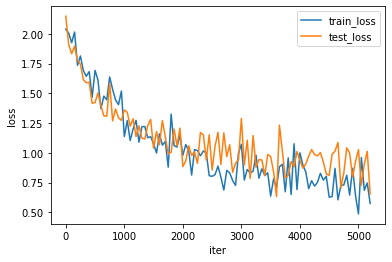

Accuracy of the network on the train images: 83.57 %
Accuracy of the network on the test images: 75.54 %


In [9]:
net = Net_dropout()  #Dropoutを使用するネットワークの生成
net.to(device)  #ネットワークをGPUへ転送

#損失関数と optimizer の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss, test_loss = train(net, criterion, optimizer)  # ネットワークを訓練する
show_loss(train_loss, test_loss) # 損失の変遷を表示する
acc = check_accuracy(net) # ネットワークの予測精度を計算する関数

Dropout を使用しない場合と比較して"train_loss"と"test_loss"の乖離が抑えられていることが分かります．

## **4 Data augmentation**

ここでは過学習を抑制するテクニックの一つである Data augmentation の実験を行います．

Data augmentation とはデータを訓練に使用する際に回転，拡大縮小，明度の調整，ガウスノイズなど様々な手段で微修正するテクニックのことです．
Data augmentation を行うことで単純に訓練に使用できる画像の数（バリエーション）が増加し，より良い汎化性能を期待できます．


また訓練画像数を増やすというよりもむしろネットワークに物体のバリエーションに関する知識（どこが変化しても概念の同一性が保たれるか）を与えていると考えることもできます．
例えばサッカーボールは左右上下反転しても同一性が保たれますが，文字"b,d,q,p"などは左右上下反転に対して意味が変化してしまいます．Data augmentation を行う際はどのような変換を行うか十分に注意する必要があります．

**PyTorch で Data augmentation を行う場合は dataset を作成する際の変換器に組み込むことができます．**
また左右反転などの変換は torchvision で容易に実現できます．

以下のコードでランダムに
- 左右反転
- 拡大縮小回転

を行う dataset を作成します．

In [10]:
#Data augmentationを行う変換器の作成
transform_aug = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),  # 左右反転
     transforms.RandomAffine(degrees=0.2, scale=(0.8,1.2)),  # 拡大縮小回転
     transforms.ToTensor(),  # torch.Tensor へ変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 正規化する
     ])
 
#訓練データのダウンロードと変換設定
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_aug)
#訓練データのローダ(読み込み器)の作成
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
 
#テストデータのダウンロードと変換設定
#テストデータにはData augmentationを行わない場合も多いです．
#ただし本節では過学習を比較することが目的であるので，テストデータでも訓練データと同じ条件で損失を計算するためにData augmentationを行います．
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_aug)
#テストデータのローダ(読み込み器)の作成
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


以下のコードで Data augmentation を使用した訓練データで学習を開始します（数分かかります）．

epoch 1/15 finished
epoch 2/15 finished
epoch 3/15 finished
epoch 4/15 finished
epoch 5/15 finished
epoch 6/15 finished
epoch 7/15 finished
epoch 8/15 finished
epoch 9/15 finished
epoch 10/15 finished
epoch 11/15 finished
epoch 12/15 finished
epoch 13/15 finished
epoch 14/15 finished
epoch 15/15 finished
Finished Training


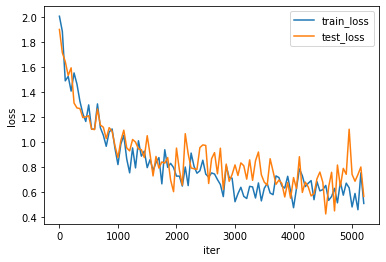

Files already downloaded and verified
Files already downloaded and verified
Accuracy of the network on the train images: 84.60 %
Accuracy of the network on the test images: 80.02 %


In [11]:
net = Net()  #ネットワークの生成
net.to(device)  #ネットワークをGPUへ転送

#損失関数と optimizer の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss, test_loss = train(net, criterion, optimizer)  # ネットワークを訓練する
show_loss(train_loss, test_loss) # 損失の変遷を表示する
 
#予測精度計算にはData augmentationを使用しない
#変換器をData augmentationしないものへ戻す
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

acc = check_accuracy(net) # ネットワークの予測精度を計算する

Data augmentation を使用しない場合と比較して"train_loss"と"test_loss"の乖離が抑えられていることが分かります．

# **交差検証**

交差検証（Cross Validation）とはモデルの**汎化性能の推定**を行う方法の一つです．
本節では特に**K-分割交差検証**（K-fold Cross Validation）について扱います．

これまでは
1. データ全体を訓練データとテストデータに分割する
2. 訓練データでモデルを訓練し，テストデータを使用して評価する

という手順でモデルの汎化性能を評価してきました．

しかしどのようにデータを訓練とテストに分割するのかによって数値上の汎化性能に差が出てしまいます．これはテストデータに偏ったデータが集まってしまった場合により顕著になります．

そこでK-分割交差検証では
1. データ全体をK個のグループに分割する
2. k個目のグループをテストデータ，残りのグループを訓練データとしてモデルを訓練する
3. 2をk = 1 ~ KにわたりK回繰り返す
4. 各回モデルのテストデータに対する性能を平均して汎化性能とする

という手順を取ります．これに計算量は増加しますが，より正確な汎化性能の評価を行うことができます．


## **0 準備**

K-分割交差検証を行うための準備をします．
モデルには先ほどに使用したCIFAR-10の分類モデルを使用します．

訓練データとテストデータを一度結合してからK個に分割を行います．
以下のコードを実行することでCIFAR-10のデータセットの結合を行います．

In [12]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Dataset, Subset
 
#訓練データのダウンロードと変換設定
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#テストデータのダウンロードと変換設定
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
#dataset の結合
#作成する allset には全データが含まれます．
allset = torch.utils.data.ConcatDataset([trainset, testset])

Files already downloaded and verified
Files already downloaded and verified


## **1 K-分割交差検証**

実際にK-分割交差検証を動かしてみます．

実行に時間がかかってしまうため今回は少なめのK=3での分割を行います．
また学習量も少なめに設定してあります．

以下のコードを実行すると3-分割交差検証を開始します（数分かかります）．

fold 1/3
epoch 1/5 finished
epoch 2/5 finished
epoch 3/5 finished
epoch 4/5 finished
epoch 5/5 finished
Finished Training


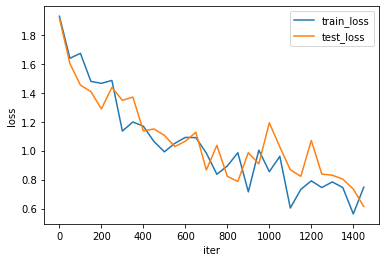

Accuracy of the network on the train images: 76.36 %
Accuracy of the network on the test images: 71.08 %
fold 2/3
epoch 1/5 finished
epoch 2/5 finished
epoch 3/5 finished
epoch 4/5 finished
epoch 5/5 finished
Finished Training


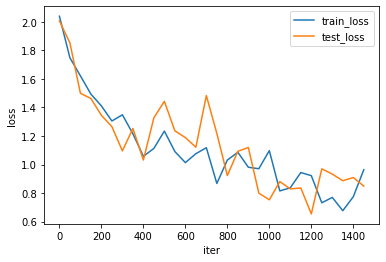

Accuracy of the network on the train images: 75.09 %
Accuracy of the network on the test images: 69.48 %
fold 3/3
epoch 1/5 finished
epoch 2/5 finished
epoch 3/5 finished
epoch 4/5 finished
epoch 5/5 finished
Finished Training


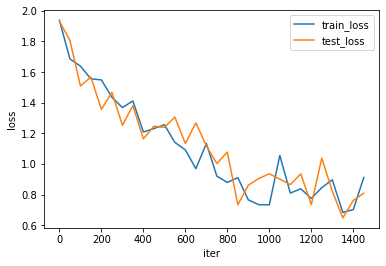

Accuracy of the network on the train images: 76.39 %
Accuracy of the network on the test images: 70.64 %


Average train accuracy : 75.95 %
Average test accuracy : 70.40 %


In [13]:
#分割数(K)
n_splits = 3

#分割用関数定義
#幾つに分割するか，整列された状態で分割するかランダムに分割するかなどを設定できます．
#この関数にデータセットを渡すことで分割を行えます．
fold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

train_acc_ls = []
test_acc_ls = []
#fold.split でデータセットの分割を行います．
#返値はデータそのものでなくデータを指すインデックスとなります．
# for と組み合わせることで各回の訓練インデックスとテストインデックスを順番に取得できます．
for fold_idx, (train_idx, test_idx) in enumerate(fold.split(allset)):
    
    print('fold {}/{}'.format(fold_idx+1,n_splits))
    net = Net()  #ネットワークの生成
    net.to(device)  #ネットワークをGPUへ転送

    #損失関数と optimizer の定義
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    #trainsetとtestsetの作成
    #全データを含む allset を訓練インデックスとテストインデックスに応じて分割します．
    #Subset を使用して allset からインデックスに対応するデータを抜き出し，データセットを作成します．
    trainloader = DataLoader(Subset(allset, train_idx), shuffle=True, batch_size=batch_size)
    testloader = DataLoader(Subset(allset, test_idx), shuffle=True, batch_size=batch_size)

    train_loss, test_loss = train(net, criterion, optimizer, n_epoch=5)  # ネットワークを訓練する
    show_loss(train_loss, test_loss) # 損失の変遷を表示する
    train_acc, test_acc = check_accuracy(net) # ネットワークの予測精度を計算する
    train_acc_ls.append(train_acc)
    test_acc_ls.append(test_acc)

#K-分割交差検証による評価を表示する
print('\n\nAverage train accuracy : {:.2f} %\nAverage test accuracy : {:.2f} %'.format(np.average(train_acc_ls),np.average(test_acc_ls)))

データの分割の仕方によって微妙に汎化性能が異なることが分かります（パラメタの初期値などの影響もあります）．

K-分割交差検証ではこれら複数回の結果を平均することで信頼性を高めています．